# Simulations with Gammapy

Here we show how to simulate the properties of one or more sources in a given field of view with the use of Gammapy. The basic ingredients are:
- a [SkyModel](https://docs.gammapy.org/1.2/api/gammapy.modeling.models.SkyModel.html) to simulate, i.e. the source properties (spectral, spatial and temporal) plus the background;
- a [Dataset](https://docs.gammapy.org/1.2/api/gammapy.datasets.Dataset.html), which carries information on the FoV geometry, the energy range, the IRF properties and so on;
- an [Observation](https://docs.gammapy.org/1.2/api/gammapy.data.Observation.html) object, which defines the exposure time, the starting time of the simulation, the pointing direction, the array configuration etc;

Then we can set the simulator class and perform the event sampling on the given sky-model.

Let's start with some basic imports:

In [1]:
import matplotlib.pyplot as plt

import time
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time
from gammapy.data import Observation, observatory_locations, FixedPointingInfo
from gammapy.datasets import MapDataset, MapDatasetEventSampler
from gammapy.irf import load_irf_dict_from_file
from gammapy.makers import MapDatasetMaker
from gammapy.maps import MapAxis, RegionNDMap, WcsGeom, Map
from gammapy.modeling.models import (
    ConstantSpectralModel,
    FoVBackgroundModel,
    LightCurveTemplateTemporalModel,
    GaussianTemporalModel,
    ConstantTemporalModel,
    ExpDecayTemporalModel,
    PointSpatialModel,
    GaussianSpatialModel,
    PowerLawSpectralModel,
    SkyModel,
    Models
)

## 1. Creation of the sky-model

First of all, we need define the source model. 

For simplicity, we consider a point-like source with a powerlaw spectral shape, at a random position (here Ra, Dec = 335°, 3°). 

We will not include temporal variability (but if you like, there are some examples in the box below..). 


For more models, please visit the Gammapy website at https://docs.gammapy.org/2.0/user-guide/model-gallery/index.html#model-gallery .

In [2]:
target = SkyCoord("335 deg", "3 deg", unit="deg", frame="icrs")
spatial_model = PointSpatialModel.from_position(target)

spectral_model = PowerLawSpectralModel(index=2, amplitude="1e-11 cm-2 s-1 TeV-1", reference="1 TeV")
temporal_model = ConstantTemporalModel()

Gammapy collects the spatial, temporal and spectral information into a single object, called `SkyModel`:

In [3]:
source_model = SkyModel(spectral_model=spectral_model,
                        spatial_model=spatial_model,
                        temporal_model=temporal_model,
                        name="fake_src")
print(source_model)

SkyModel

  Name                      : fake_src
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : ConstantTemporalModel
  Parameters:
    index                         :      2.000   +/-    0.00             
    amplitude                     :   1.00e-11   +/- 0.0e+00 1 / (TeV s cm2)
    reference             (frozen):      1.000       TeV         
    lon_0                         :    335.000   +/-    0.00 deg         
    lat_0                         :      3.000   +/-    0.00 deg         




We need to include the background as well. Let's consider the model taken from the IRF:

In [4]:
bkg = FoVBackgroundModel(dataset_name="my-dataset")

The full model (i.e. source plus background) can be stored into the `Models` object. It can handle a number of models!

In [5]:
full_model = Models([source_model, bkg])
print(full_model)

Models

Component 0: SkyModel

  Name                      : fake_src
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : ConstantTemporalModel
  Parameters:
    index                         :      2.000   +/-    0.00             
    amplitude                     :   1.00e-11   +/- 0.0e+00 1 / (TeV s cm2)
    reference             (frozen):      1.000       TeV         
    lon_0                         :    335.000   +/-    0.00 deg         
    lat_0                         :      3.000   +/-    0.00 deg         

Component 1: FoVBackgroundModel

  Name                      : my-dataset-bkg
  Datasets names            : ['my-dataset']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    tilt                  (frozen):      0.000                   
    norm                          :      1.000   +/-    0.00             
    reference             (fro

## 2. Creation of the simulation dataset

Let's load the IRF to be used for the simulation. Then, let's define the energy range, the pointing coordinates, the exposure time and the size of the field of view. We will then have all necessary information to create our fake observation.

### Loading an IRF for the South array:

In [6]:
path = "$GAMMAPY_DATA/cta-caldb/Prod5-South-20deg-AverageAz-14MSTs37SSTs.180000s-v0.1.fits.gz"
irf = load_irf_dict_from_file(path)

**Note:** Check how look like these IRFs (always IMPORTANT to have a look)

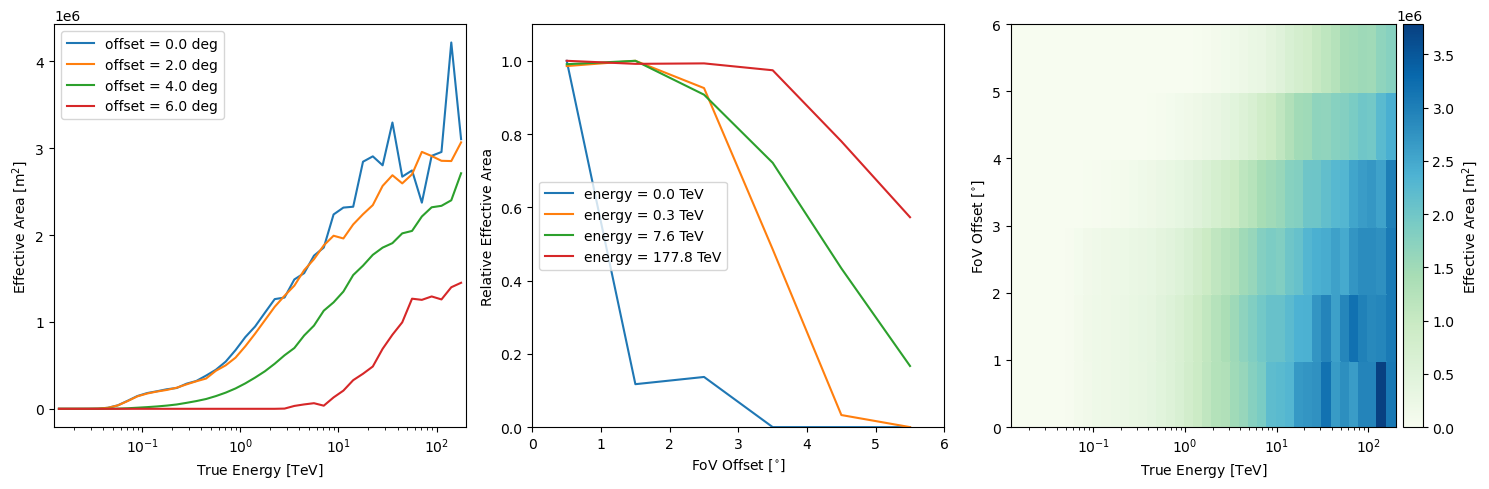

In [7]:
irf["aeff"].peek()

### Definition of the energy range

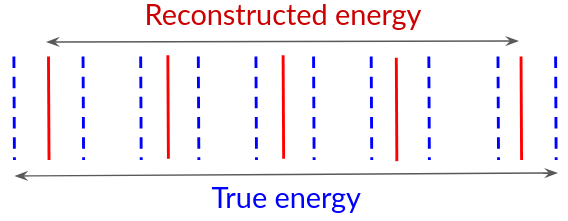

In [8]:
# true energy: we create an axis to calculate the gamma IRFs (effective area, energy dispersion, psf):
energy_axis_true = MapAxis.from_energy_bounds("0.01 TeV", "90 TeV", 
                                         nbin=10, per_decade=True, 
                                         name="energy_true")
# reconstructed energy:
energy_axis = MapAxis.from_energy_bounds("0.05 TeV", "70 TeV",
                                         nbin=5, per_decade=True)



### Observation time

In [9]:
# Let's assume an exposure time of 5 hours:
livetime = 5 * u.hr

# Let's assume that we have a deadtime of 5%
deadtime = 0.05

### Definition of the geometry

In [10]:
# We can define a FoV geometry of a square of 5° by side and a square pixel of 0.01° by side, centered 
# at the pointing position:

geom = WcsGeom.create(
            skydir=target,
            width=(5, 5),
            binsz=0.01, 
            frame="galactic",
            axes=[energy_axis],
            )

### Creation of the fake observation
Now we can create the `Observation` object to store all the needed information for the observation. We assume that the observation starts today: 

In [11]:
time_ref = Time("2024-06-25T00:00:00", format="isot", scale="utc")
pointing = FixedPointingInfo(
    fixed_icrs=target.icrs,
)

observation = Observation.create(
            obs_id="0001",
            pointing=pointing,
            livetime=livetime,
            deadtime_fraction=deadtime,
            irfs=irf,
            reference_time=time_ref,
            )

### Creation of the simulation dataset
Finally, we can create the `Dataset` object and we fill it with the full sky-model:

In [12]:
empty = MapDataset.create(
            geom,
            energy_axis_true=energy_axis_true,
            name="my-dataset",
            )
maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"])
dataset = maker.run(empty, observation)

In [13]:
dataset.models = full_model

In [14]:
print(dataset)

MapDataset
----------

  Name                            : my-dataset 

  Total counts                    : 0 
  Total background counts         : 980950.08
  Total excess counts             : -980950.08

  Predicted counts                : 988860.04
  Predicted background counts     : 980950.08
  Predicted excess counts         : 7909.96

  Exposure min                    : 7.42e+01 m2 s
  Exposure max                    : 5.29e+10 m2 s

  Number of total bins            : 4000000 
  Number of fit bins              : 4000000 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 1977720.09

  Number of models                : 2 
  Number of parameters            : 8
  Number of free parameters       : 5

  Component 0: SkyModel
  
    Name                      : fake_src
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : PointSpatialModel
    Temporal model type       : ConstantTemporalMode

## Let's simulate the events:

In [15]:
dataset.fake()

In [16]:
print(dataset)

MapDataset
----------

  Name                            : my-dataset 

  Total counts                    : 990058 
  Total background counts         : 980950.08
  Total excess counts             : 9107.92

  Predicted counts                : 988860.04
  Predicted background counts     : 980950.08
  Predicted excess counts         : 7909.96

  Exposure min                    : 7.42e+01 m2 s
  Exposure max                    : 5.29e+10 m2 s

  Number of total bins            : 4000000 
  Number of fit bins              : 4000000 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 2169081.02

  Number of models                : 2 
  Number of parameters            : 8
  Number of free parameters       : 5

  Component 0: SkyModel
  
    Name                      : fake_src
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : PointSpatialModel
    Temporal model type       : ConstantTemporalMo

In [17]:
# To plot, eg, counts:
dataset.counts.smooth(0.05 * u.deg).plot_interactive(
    add_cbar=True, stretch="linear"
)

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

## Open problems: 

6a) Simulate a source with an extended morphology (for example, a Gaussian spatial extensions with size 0.5°) and a powerlaw spectral shape ($\Gamma=2$, amplitude=$10^{-13}$ cm$^{-2}$ s$^{-1}$ TeV$^{-1}$ at 1 TeV). Determine then minimum exposure time needed to constrain the extension of the source to better than 10%; for simplicity, consider a FoV dimension of $2.5°\times2.5°$ and fix the source coordinates when fitting the model to the sampled data.
 
6b) Consider the extended Galactic source RX J1713-3946, located at 1 kpc from us. Its coordinates are l, b = 347.313895°, -0.459872° and its spectrum can be modeled with a powerlaw of $\Gamma=2.06$ and amplitude of $2.3\times10^{-11}$ cm$^{-2}$ s$^{-1}$ TeV$^{-1}$ at 1 TeV.
Simulate it and fit the sampled events to estimate the constraints on the size of its morpholgy. Then, move the source to larger distances, rescaling the powerlaw amplitude and the source size accordingly, and estimate its morphology. Calculate how the constraints on the size change with the distance. For simplicity, consider an exposure time of 10 hours and fix the source coordinates when fitting the model.